# Amazon Product Review Feature Engineering Notebook

The purpose of this notebook is to perform some feature engineering on the Amazon Product Review Data. The overall scope of this project is to determine if product reviews on Amazon.com have any sort of impact on the overall sales ranking of any particular item. The data was obtain with permission from the following paper:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [14]:
#First import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
#First load the data

rev = pd.read_csv('Data/ProcessedAmazonReviewData1500k.csv', index_col=False)
rev.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,...,brand,rank,main_cat,price,rankCat,parent,catRank,Ranking,salesRanking,ratingPrice
0,5.0,True,"05 27, 2016",A1RCEZ4VG7W6Q4,B0000CFN85,Mary Payne Kinnamon,Quality thick paper and worked wonders for my ...,Five Stars,1464307200,"['Home & Kitchen', 'Kitchen & Dining', 'Bakewa...",...,Wilton,"['>#9,714 in Kitchen & Dining (See Top 100 in ...",Amazon Home,3.43,"[""9,714 in Kitchen & Dining (See Top 100 in Ki...",B0000CFN85,29 in Kitchen & Dining > Bakeware > Baking Too...,29.0,567.0,17.15
1,5.0,True,"08 15, 2014",A3LTJ22VDCATD1,B001BN8Z2K,Mom of 4,Covers more area in a shorter amount of time. ...,Large head cuts down your work time - twists l...,1408060800,"['Home & Kitchen', 'Vacuums & Floor Care', 'Va...",...,Miele,"['>#47,359 in Home & Kitchen (See Top 100 in H...",Amazon Home,57.85,"[""47,359 in Home & Kitchen (See Top 100 in Hom...",B001BN8Z2K,38 in Home & Kitchen > Vacuums & Floor Care > ...,38.0,558.0,289.25
2,5.0,True,"12 30, 2016",A9OHV8NJ03WVH,B0026SPXRY,Susana Pachas,It's great! Easy to assemble and sturdy it's ...,It's great! Easy to assemble and sturdy it's n...,1483056000,"['Home & Kitchen', 'Furniture', 'Kitchen & Din...",...,Whitmor,"['>#2,026 in Home & Kitchen (See Top 100 in Ho...",Amazon Home,28.93,"['2,026 in Home & Kitchen (See Top 100 in Home...",B0026SPXRY,1 in Home & Kitchen > Furniture > Kitchen & Di...,1.0,595.0,144.65
3,4.0,True,"09 28, 2015",AT3P07T5RVNTQ,B00ESAR0JW,Hstar13,We haven't had a real oven for over a year now...,"This cooks most things pretty well, but you ha...",1443398400,"['Home & Kitchen', 'Kitchen & Dining', 'Small ...",...,Hamilton Beach,"['>#6,672 in Kitchen & Dining (See Top 100 in ...",Amazon Home,7.05,"[""6,672 in Kitchen & Dining (See Top 100 in Ki...",B0059KY05M,73 in Kitchen & Dining > Small Appliances > Ov...,73.0,523.0,28.20
4,3.0,True,"06 23, 2017",A4I78M7IQPW12,B0074V10JS,Pamela,Nice bedskirt but won't work with a bed that h...,Nice bedskirt,1498176000,"['Home & Kitchen', 'Bedding', 'Bed Skirts']",...,Hdetails,"['>#76,184 in Home & Kitchen (See Top 100 in H...",Amazon Home,12.99,"[""76,184 in Home & Kitchen (See Top 100 in Hom...",B0074V10JS,95 in Home & Kitchen > Bedding > Bed Skirts'],95.0,501.0,38.97


The first feature to add to the data set will be the average rating for each product. However, due to the volume of items available on the Amazon marketplace, I suspect there will be quite a few items that will only have one review. We'll take a look at the number of unique items and the overall number of items. 

In [3]:
print('The number of duplicate reviews is:', rev.shape[0]-len(rev['asin'].unique()))
print('The number of unique items reviewed is:', len(rev.asin.unique()))

The number of duplicate reviews is: 986065
The number of unique items reviewed is: 15739


In [4]:
#Lets take a look at the count of the unique categories.
rev.main_cat.value_counts()

Amazon Home                                                                                                                                                                 955993
Tools & Home Improvement                                                                                                                                                     21171
Industrial & Scientific                                                                                                                                                       4649
Arts, Crafts & Sewing                                                                                                                                                         3095
Toys & Games                                                                                                                                                                  2984
Office Products                                                                                          

In [5]:
#In order to ensure the I want to ignore any categories that only appear a couple times. This will ensure that there are no
#surprise categorical variables in the split data set.
#filtered = rev.groupby('main_cat')['main_cat'].filter(lambda x: len(x) < 500)
#rev2 = rev[rev['main_cat'].isin(filtered)]

We need to group categories that are very infrequent into a miscellaneous category to avoid any issues when the test data is transformed with the PCA that was trained on a potenitally different set of main categories. If we simply drop these data rather than binning then the training data is nearly identical to the testing data and there is a significant degree of data leakage resulting in unreasonably high R-Squared values on the test data (as high as 100%). 

In [4]:
# First I'll create a dict of all of the value counts for the unique categories, then use a lambda function to recategorize 
# any categories that have fewer than 1000 products. 

cat_count = dict(rev.main_cat.value_counts())
rev['main_cat'] = rev.main_cat.apply(lambda x: x if cat_count[x] > 1000 else 'Misc.')


In [5]:
#Now that these data are recategorized, lets have a look at the categories. 
rev.main_cat.value_counts()

Amazon Home                 955993
Tools & Home Improvement     21171
Industrial & Scientific       4649
Arts, Crafts & Sewing         3095
Toys & Games                  2984
Office Products               2958
Misc.                         2452
Automotive                    2235
Health & Personal Care        2206
All Beauty                    1622
Sports & Outdoors             1411
Home Audio & Theater          1028
Name: main_cat, dtype: int64

Lets take a look at the brands included in the data. This could also be another feature that could cause problems with the PCA step if there are differences in the brand between the training and testing data. Additionally, a very large number of brands may also cause memory issues with when trying to allocate the space for the PCA. Again I'll need to re-assign brand if the brand is infrequent. 

In [8]:
#Lets start by looking at the number of unique brands
rev.brand.nunique()

4707

In [9]:
# This is a large number of unique brands. Lets see how much we cna reduce this

rev.brand.value_counts()

OXO                        28681
Cuisinart                  20038
InterDesign                18841
Hamilton Beach             15673
Norpro                     12747
                           ...  
Creative Stuff Glass           9
Certified International        8
Three Geese                    8
Amariver                       8
Dawhud Direct                  7
Name: brand, Length: 4707, dtype: int64

In [10]:
# Now lets bin the brands with limited numbers.

brand_counts = dict(rev.brand.value_counts())

rev['brand'] = rev.brand.apply(lambda x: x if brand_counts[x] > 300 else 'Misc.')

In [11]:
#Now that these have been binned, lets take a look at the value counts again
rev.brand.nunique()

572

It appears about half of the products have been reviewed more than once, but that shouldn't be an issue for this review. I'll calculate the average rating as well as the count of the reviews. 

In [12]:
rev['AvgRating'] = rev['overall'].groupby(rev.asin).transform('mean')
rev['RatingCount'] = rev['overall'].groupby(rev.asin).transform('sum')

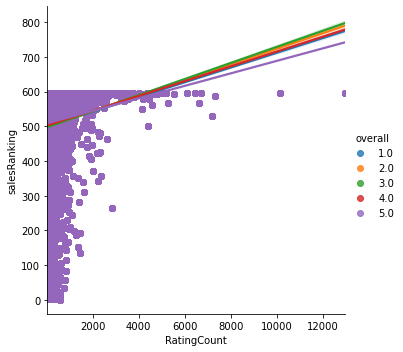

In [13]:
sns.lmplot(x = 'RatingCount', y = 'salesRanking', data = rev, hue = 'overall')


Text(0.5, 20.80000000000002, 'Average Rating')

<Figure size 1008x576 with 0 Axes>

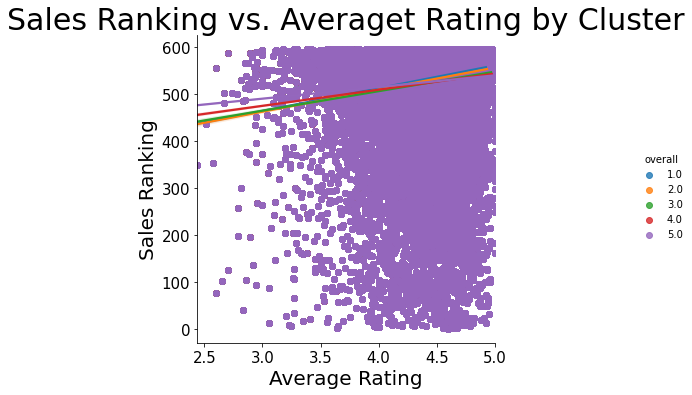

In [13]:

sns.lmplot(x='AvgRating', y = 'salesRanking', data = rev, hue = 'overall')
plt.title('Sales Ranking vs. Average Rating by Cluster')
plt.ylabel('Sales Ranking')
plt.xlabel('Average Rating')

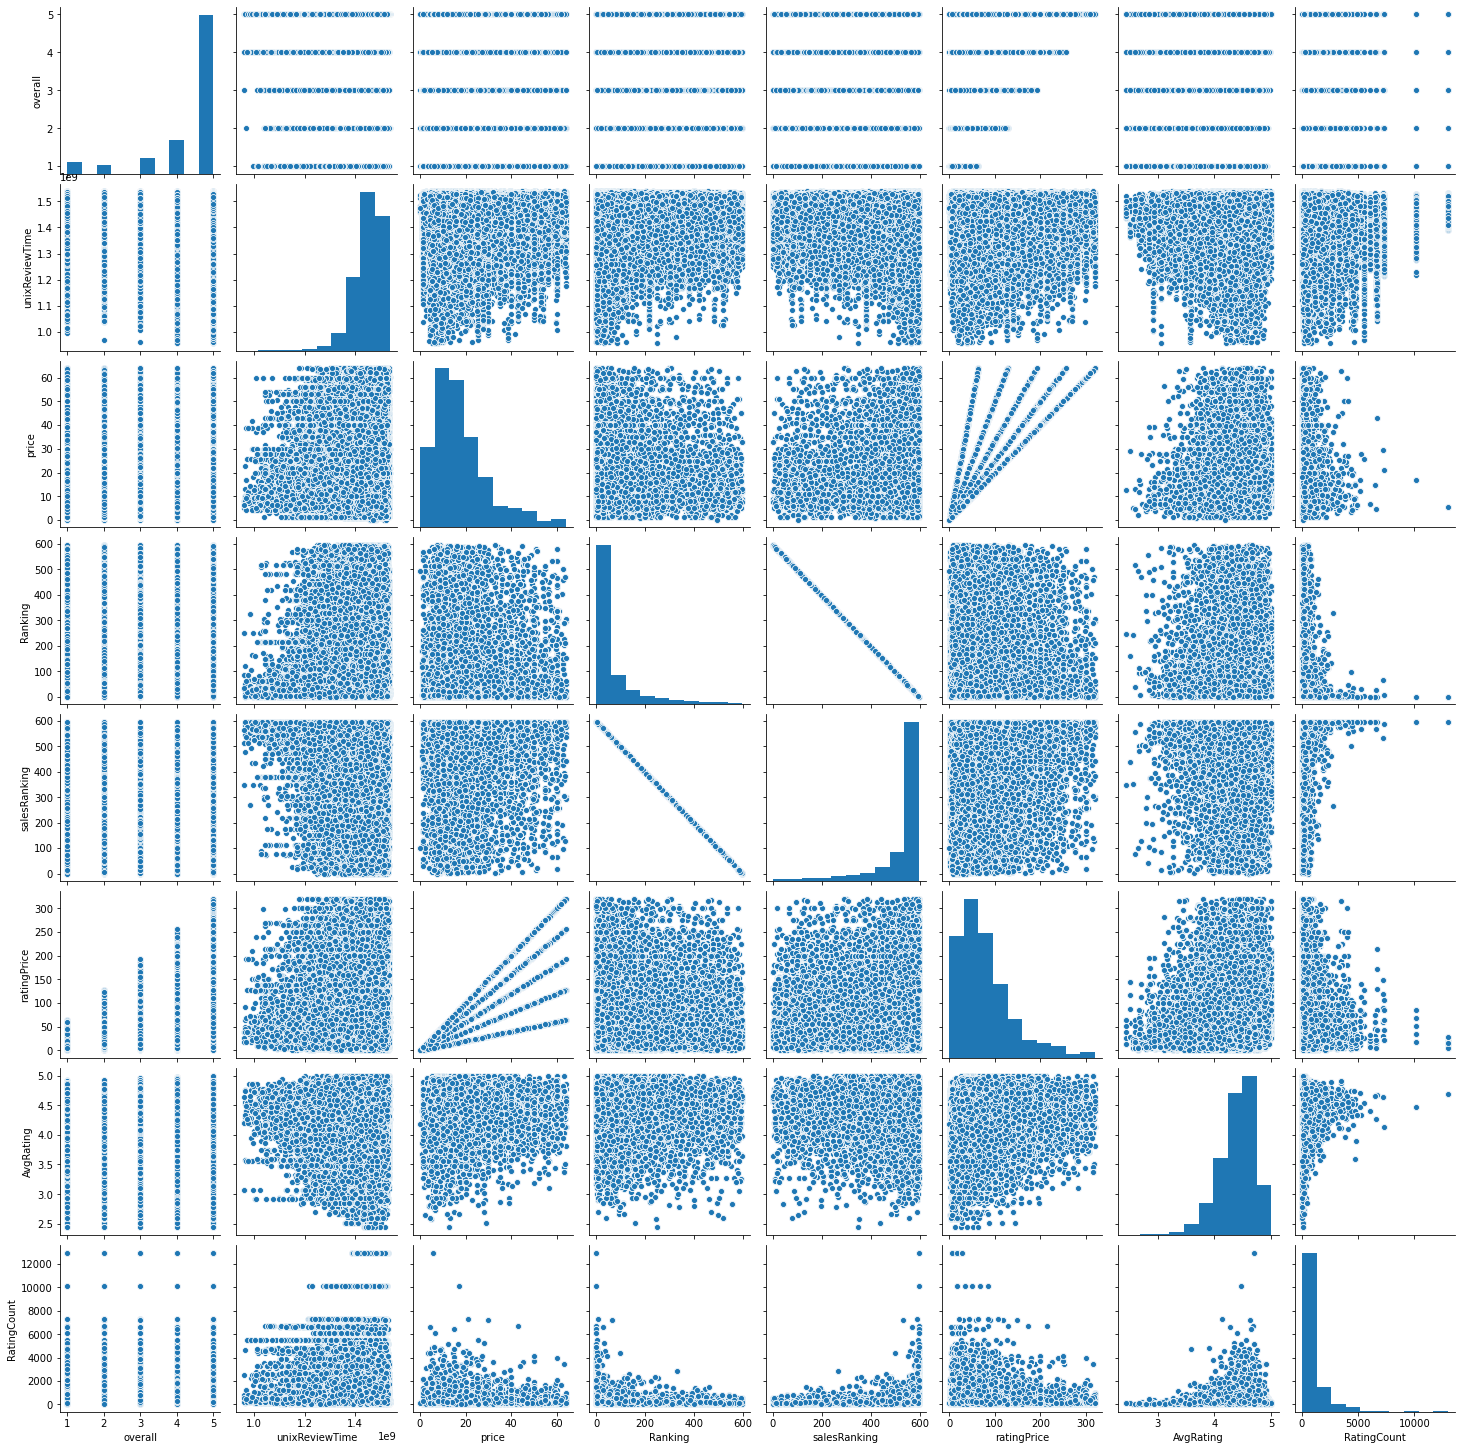

In [11]:
sns.pairplot(rev.drop('verified', axis = 1))

Next I want to create a continuous variable to reflect the sentiment of the review. 
This function will utilize the VADER sentiment analyzer and will average the sentiment of all sentances
in the review. The final variable will be the average of the compound score reported by VADER.

In [12]:
#First I need to import the subjectivity and VADER packages from nltk
import nltk
from nltk.corpus import subjectivity
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#The function creates an instance of the sentiment analyzer and tokenizes the review into sentances. 
#the sentiment of each sentance is stored in a list and the mean of the compound score is taken and returned. 
#If the review contains no text, then 0 is returned (equivalent of a neutral review)
def getSentiment(review):
    sid = SentimentIntensityAnalyzer()
    if len(review) == 0:
        return 0
    elif len(tokenize.sent_tokenize(review)) == 1:
        return sid.polarity_scores(review)['compound']
    sentiment = []
    for sentance in tokenize.sent_tokenize(review):
        ss = sid.polarity_scores(sentance)
        sentiment.append(ss['compound'])
    return np.mean(sentiment)

In [13]:
#Now apply the function to the dataframe and store the results in a new column. 
rev['reviewSentiment'] = rev['reviewText'].apply(getSentiment)

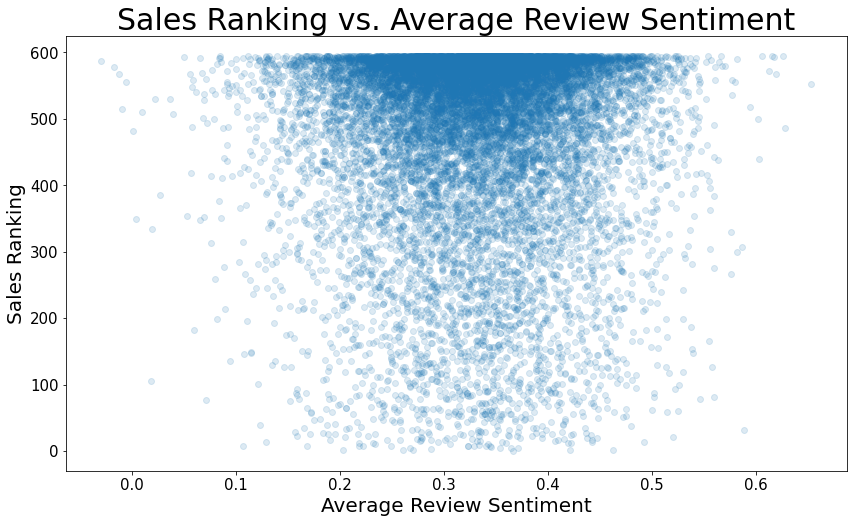

In [27]:
fig = plt.figure(figsize = (14, 8))
plt.scatter(rev.groupby(['asin'])['reviewSentiment'].mean(), rev.groupby(['asin'])['salesRanking'].mean(), alpha = 0.15)
plt.title('Sales Ranking vs. Average Review Sentiment', fontsize = 30)
plt.ylabel('Sales Ranking', fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('Average Review Sentiment', fontsize = 20)
plt.savefig('SalesRankingvsSentiment.pdf', format = 'pdf')

In [15]:
#Next I'd like to get the sentiment of the summary. Hopefully these values are similar...
rev['summarySentiment'] = rev['summary'].apply(getSentiment)

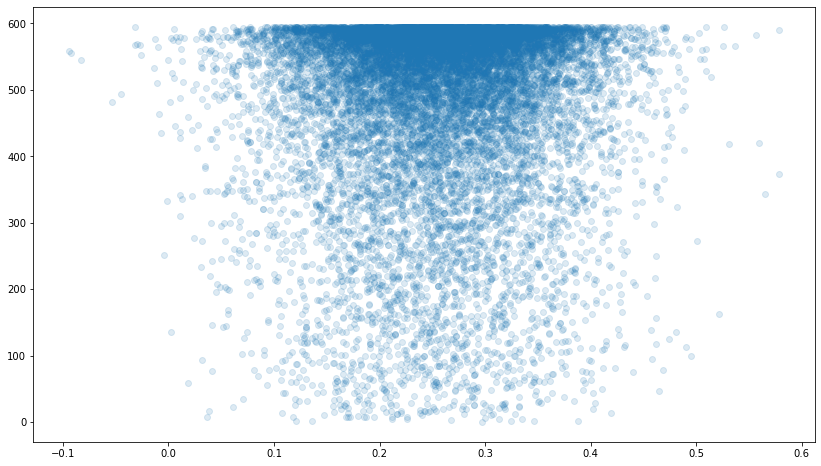

In [22]:
fig = plt.figure(figsize = (14, 8))
plt.scatter(rev.groupby('asin').summarySentiment.mean(), rev.groupby('asin').salesRanking.mean(), alpha = 0.15)

In [16]:
rev.summarySentiment.fillna(value = 0, inplace = True)
pd.isnull(rev).sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
reviewerName        0
reviewText          0
summary             0
unixReviewTime      0
category            0
title               0
brand               0
rank                0
main_cat            0
price               0
rankCat             0
parent              0
catRank             0
Ranking             0
salesRanking        0
ratingPrice         0
AvgRating           0
RatingCount         0
reviewSentiment     1
summarySentiment    0
dtype: int64

In [17]:
rev.dropna(axis=0, how = 'any', inplace = True)

In [18]:
rev.describe()

,overall,unixReviewTime,price,Ranking,salesRanking,ratingPrice,AvgRating,RatingCount,reviewSentiment,summarySentiment
count,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06,1.001803e+06
mean,4.392786e+00,1.451739e+09,1.804873e+01,7.207340e+01,5.239266e+02,7.958302e+01,4.392787e+00,9.396151e+02,3.231892e-01,2.554627e-01
std,1.103661e+00,5.528197e+07,1.232134e+01,1.117270e+02,1.117270e+02,5.951003e+01,3.166493e-01,1.376786e+03,2.763909e-01,3.245812e-01
min,1.000000e+00,9.580896e+08,5.000000e-02,1.000000e+00,0.000000e+00,5.000000e-02,2.439024e+00,2.300000e+01,-9.856000e-01,-9.406000e-01
25%,4.000000e+00,1.422144e+09,8.970000e+00,5.000000e+00,5.110000e+02,3.597000e+01,4.214651e+00,1.960000e+02,1.339667e-01,0.000000e+00
50%,5.000000e+00,1.459382e+09,1.498000e+01,2.300000e+01,5.730000e+02,6.490000e+01,4.441718e+00,4.520000e+02,3.294000e-01,2.023000e-01
75%,5.000000e+00,1.490659e+09,2.300000e+01,8.500000e+01,5.910000e+02,1.039600e+02,4.625000e+00,1.063000e+03,5.326500e-01,5.719000e-01
max,5.000000e+00,1.538525e+09,6.399000e+01,5.960000e+02,5.950000e+02,3.199500e+02,5.000000e+00,1.297200e+04,9.996000e-01,9.829000e-01


In [19]:
#Next I want to create a variable to capture the length of the review to determine if the length has any impact on the Ranking. 

#Create a regex tokenizer to drop punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
#Now apply the tokenizer to each review and count the lenth
rev['reviewLength'] = rev['reviewText'].apply(lambda x: len(tokenizer.tokenize(x)) if len(x) > 0 else 0)

<AxesSubplot:>

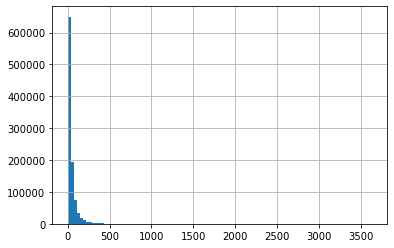

In [20]:
#Lets have a look at the results:
rev['reviewLength'].hist(bins=100)

In [21]:
#Lastly I need to convert 'verified' from boolean to binary.

rev.verified.replace({True:1, False:0}, inplace=True)

I'm curious to see if there are any hidden patterns in the data that I can use as a predictor variable. I'll use the KMeans clustering algorithm from sklearn to engineer some clusters. The first step will be to determine the number of clusters to use. I'll accomplish this using the elbow plot method. First I need to create an X vector for the KMeans algorithm. Then I'll test the variance explained by 1 to 50 clusters. Once we have the clusters we can append them to the data and look for interaction terms.

In [46]:
rev.to_csv('Data/rev_noPCA.csv', index = False)

In [8]:
rev = pd.read_csv('Data/rev_noPCA.csv', index_col = False)

In [3]:
#First I need to prepare the data for the KMeans algorithm. I'll start by dropping categorical columns. 
#I also need to split the data into train and test groups. 

x_train, x_test, y_train, y_test = train_test_split(rev.drop(['salesRanking'], axis=1), rev.salesRanking, )

obs = []
[obs.append(col) for col in x_train.columns if rev[col].dtype == 'O']
xClf = x_train.drop(obs, axis = 1)

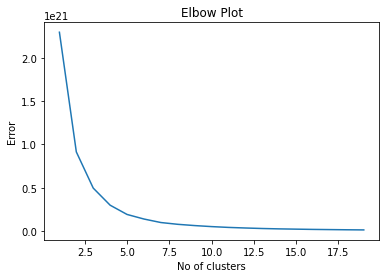

In [7]:
#Run through the number of clusters ranging form 1 to 50. 

from sklearn.cluster import KMeans
Error = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(xClf)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 20), Error)
plt.title('Elbow Plot')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [9]:
#I'll plan to use 8 clusters. Now I need to generate the features and append them to the dataframe. 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 7, random_state = 123)
kmeans.fit(xClf)
clusters = kmeans.predict(xClf)
x_train['clusters'] = clusters

In [10]:
x_train.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'parent',
       'catRank', 'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount',
       'reviewSentiment', 'summarySentiment', 'reviewLength', 'clusters'],
      dtype='object')

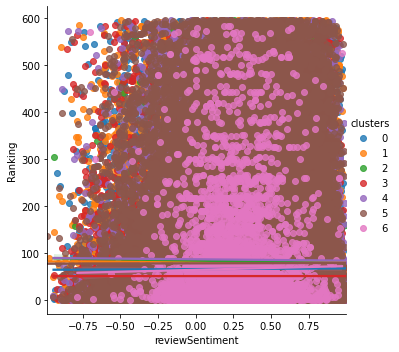

In [20]:
#Looks good. 
sns.lmplot(x='reviewSentiment', y = 'Ranking', data = x_train, hue = 'clusters')

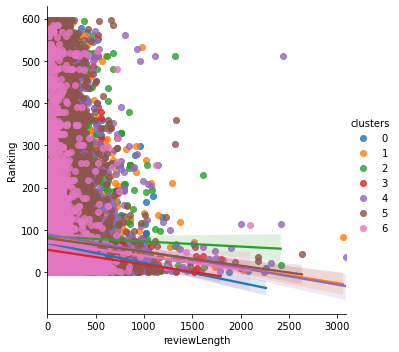

In [21]:
sns.lmplot(x='reviewLength', y = 'Ranking', data = x_train, hue = 'clusters')
#It looks like the ranking decreases as the reviews become increasingly verbose. 

In [22]:
#I'll go ahead and create an interaction term for cluster_reviewLength
x_train['clusterXreviewLength'] = x_train['clusters']*x_train['reviewLength']

Text(0.5, 1.0, 'Ranking vs Price varying by cluster')

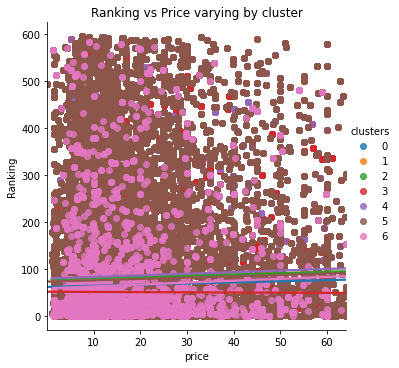

In [23]:
#Now I'll look for interaction terms using the clusters. 
#If the slopes or intercepts vary by cluster for ranking vs the other continuous variables then there are likely interactions
sns.lmplot(x = 'price', y = 'Ranking', hue = 'clusters', data = x_train)
plt.title('Ranking vs Price varying by cluster')

In [24]:
#There may also be an interaction between price and cluster. I'll create an interaction term there as well.
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs overall rating varying by cluster')

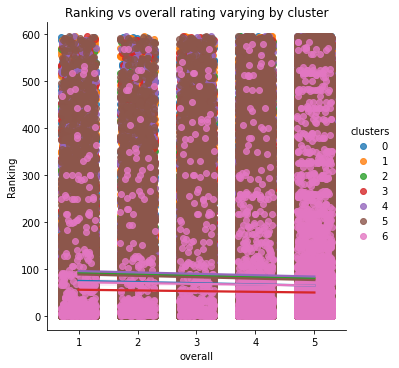

In [25]:
sns.lmplot(x = 'overall', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs overall rating varying by cluster')

In [26]:
#There may also be an interaction between cluster and overall
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs AvgRating varying by cluster')

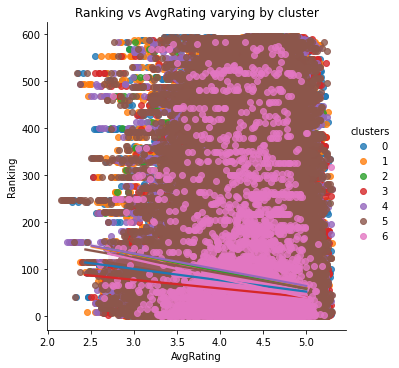

In [27]:
sns.lmplot(x = 'AvgRating', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs AvgRating varying by cluster')

In [28]:
#Create an interaction term between cluster and average rating
x_train['clusterXavgRating'] = x_train['clusters']*x_train['AvgRating']

Text(0.5, 1.0, 'salesRanking vs RatingCount varying by cluster')

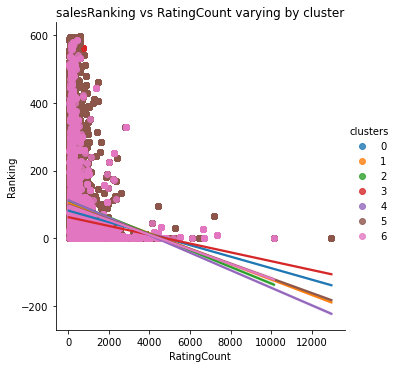

In [29]:
sns.lmplot(x = 'RatingCount', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('salesRanking vs RatingCount varying by cluster')

In [52]:
#Create an interaction between RatingCount and clusters
x_train['clusterXratingCount'] = x_train['clusters']*x_train['RatingCount']

<AxesSubplot:>

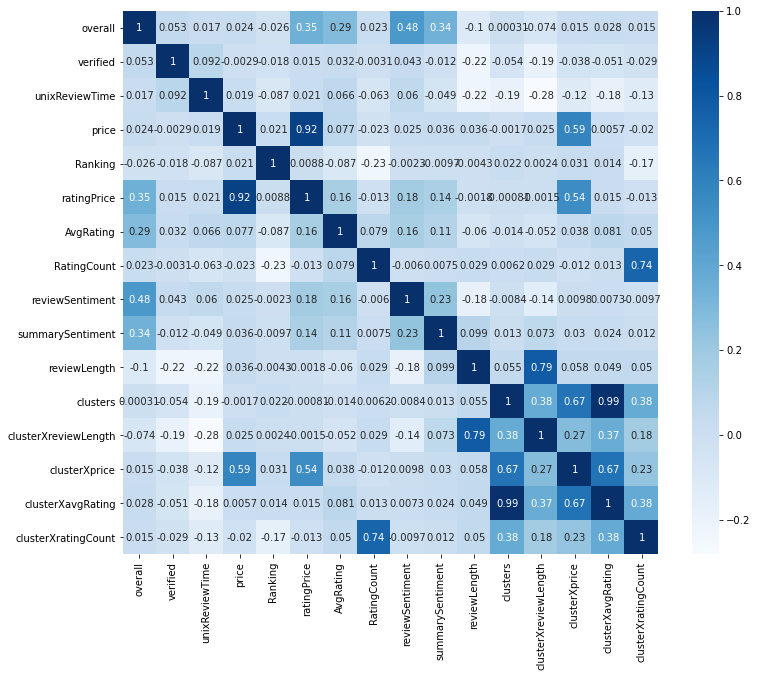

In [41]:
plt.figure(figsize = (12,10))
sns.heatmap(x_train.corr(), annot = True, cmap = 'Blues')


Now I'll need to predict the clusters for the training data as well as adding all of the additional features. It's important to use the PCA and KMeans that were fit to the training data to predict the test data. 

In [4]:
#Now I'll need to handle the categorical data. This means dropping some columns like reviewTime, reviewerID, asin, reviewerName
#reviewText, summary, category, catRank, rankCat. In the end, we need main_cat, brand and title.

x_train_categorical = pd.get_dummies(x_train[['main_cat', 'brand']])

In [12]:
print('Categorical Dummies will add %d columns to the data' %x_train_categorical.shape[1])

Categorical Dummies will add 4719 columns to the data


In [5]:
#Now that I have the dummy variables the dataset is huge. I'll try to reduce the dimensionality with PCA on the categorical variables
pca = PCA(n_components = 20)
pca.fit(x_train_categorical)
x_train_pca = pca.transform(x_train_categorical)

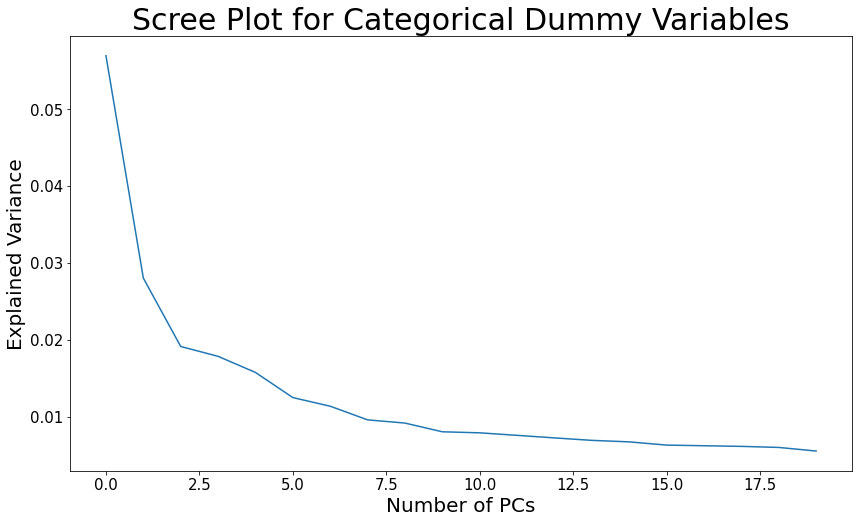

In [7]:
#I'll create a scree plot to extract the number of pertinent principle components.
fig = plt.figure(figsize = (14, 8))
plt.plot(pca.explained_variance_)
plt.xlabel('Number of PCs', fontsize = 20)
plt.ylabel('Explained Variance', fontsize = 20)
plt.title('Scree Plot for Categorical Dummy Variables', fontsize = 30)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.savefig('Scree.pdf', format = 'pdf')

In [57]:
#It looks like I only need to include the first 5.
columns= []
for i in range(0, 5):
    columns.append('PCA' + str(i))
x_train_pca = pd.DataFrame(x_train_pca[:, 0:5], columns = columns)
# Add the columns to the training data.
x_train = pd.concat([x_train.reset_index(drop=True), x_train_pca.reset_index(drop = True)], axis=1)

In [34]:
x_train.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,...,clusters,clusterXreviewLength,clusterXprice,clusterXavgRating,clusterXratingCount,PCA0,PCA1,PCA2,PCA3,PCA4
0,1.0,1,"10 13, 2017",AB3FMMN0ZD53O,B015IQLAJ0,Barbara Jean Erickson,Didn't fit my K Cup .2,One Star,1507852800,"['Home & Kitchen', 'Kitchen & Dining', 'Small ...",...,4,28,35.88,16.417910,1100.0,-0.352058,-0.021879,-0.037018,-0.016504,-0.032732
1,4.0,1,"12 2, 2016",A3FTF1IT2DGCR4,B000YGEVMI,Jose Serrano,Great item. Keep cold temperature for about 6 ...,Four Stars,1480636800,"['Home & Kitchen', 'Kitchen & Dining', 'Travel...",...,1,10,16.93,4.473313,10141.0,-0.361563,-0.024614,-0.048117,-0.024621,-0.050793
2,5.0,1,"08 31, 2017",A3CW1WXWMOK71A,B01G0ZR7JU,M. Sheehy,These were really nice for the price paid. Twi...,Nicer than expected.,1504137600,"['Home & Kitchen', 'Kitchen & Dining', 'Dining...",...,4,128,111.88,19.333333,580.0,0.641998,-0.101708,0.000642,-0.000647,0.001881
3,5.0,1,"05 12, 2017",A32SFQWF7AFTYP,B0026RI0W0,Austin,Great. No complaints!,Five Stars,1494547200,"['Home & Kitchen', 'Bath', 'Bathroom Accessori...",...,1,3,12.34,4.196721,768.0,-0.380679,-0.000713,-0.109446,-0.404726,0.865913
4,1.0,0,"05 18, 2017",A2204Z61DYM20,B00NPYJW2A,Javier Lopez,The Item came with Broken back panel. Box was ...,Damage good and no inspection prior to shipping,1495065600,"['Home & Kitchen', 'Kitchen & Dining', 'Small ...",...,1,34,4.78,4.117021,387.0,-0.357463,-0.023373,-0.042680,-0.020366,-0.041147


In [59]:
#First I'll add the clusters. I need to create a DF that drops the engineered features and the categorical features to train the KMeans model

obs = []
[obs.append(col) for col in x_test.columns if x_test[col].dtype == 'O']


#Predict the training clusters
x_test_clf = x_test.drop(obs, axis = 1)
pred_clusters = kmeans.predict(x_test_clf)
x_test['clusters'] = pred_clusters

In [60]:
#Create an interaction term for cluster_reviewLength
x_test['clusterXreviewLength'] = x_test['clusters']*x_test['reviewLength']

#Create an interaction between cluster and overall
x_test['clusterXprice'] = x_test['clusters']*x_test['price']

#Create an interaction term between cluster and average rating
x_test['clusterXavgRating'] = x_test['clusters']*x_test['AvgRating']

x_test['clusterXratingCount'] = x_test['clusters']*x_test['RatingCount']

In [61]:
x_test_categorical = pd.get_dummies(x_test[['main_cat', 'brand']])
x_test_pca = pca.transform(x_test_categorical)
x_test_pca = pd.DataFrame(x_test_pca[:, 0:5], columns = columns)
x_test = pd.concat([x_test.reset_index(drop=True), x_test_pca.reset_index(drop=True)], axis = 1)

In [62]:
#Now check to ensure the dimensions and columns match
print('Dimensions of x_train are:', x_train.shape)
print('Dimensions of x_test are:', x_test.shape)
print('Coulmns of x_train are:', x_train.columns)
print('Columns of x_test are:', x_test.columns)

Dimensions of x_train are: (751352, 35)
Dimensions of x_test are: (250451, 35)
Coulmns of x_train are: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'parent',
       'catRank', 'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount',
       'reviewSentiment', 'summarySentiment', 'reviewLength', 'clusters',
       'clusterXreviewLength', 'clusterXprice', 'clusterXavgRating',
       'clusterXratingCount', 'PCA0', 'PCA1', 'PCA2', 'PCA3', 'PCA4'],
      dtype='object')
Columns of x_test are: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'parent',
       'catRank', 'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount',
       'reviewSentiment', 'summarySentiment', 'reviewLen

Now I'll just save the data with the new features. 

In [63]:
#Save the data to a csv file
x_train.to_csv('Data/x_train1500k.csv', index = False)
y_train.to_csv('Data/y_train1500k.csv', index = False)
x_test.to_csv('Data/x_test1500k.csv', index = False)
y_test.to_csv('Data/y_test1500k.csv', index = False)